Load in the data using pandas

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier as AD
from src import function as F
from src import roc_curve as R
from src import cleaning as C
from sklearn.decomposition import PCA
from importlib import reload
from sklearn.metrics import precision_recall_curve
reload(C)

<module 'src.cleaning' from '/Users/elliottsaslow/gaalvanize/week_5_notes/churn_case_study/dsi-ml-case-study/src/cleaning.py'>

### Did a user churn?  A case study by *CHURN NATION
#### Definitions:


- **1 => CHURN**
    - The User **did not** use the ride sharing service in the last 30 days
- **0 => NO CHURN**
    - The user **did** use the ride sharing service in the last 30 days
    
-----------------

#### Problem Statement and background:
We are a ride sharing company that has a subset of users who all signed up in January. We have data on their riding patterns and want to predict if 6 months later, the user has continued to use the service.  Our metric for this is whether or not the user has ridden in the last 30 days.  

Even so, I feel that a month of non-use does not nessecarily imply churn.  **But** we still want to predict whether or not we should try to retain the user by sending a promotional.  I am going to apply a number of models to the data, see the predictions, and interpret what they mean.  

First things first, we need to do a little bit of Exploring the data, and clean it up a bit.  We built a pipline to do this, and it will take either the testing or training data and apply the same transformations.
    
#### Data Pipeline:
1. Read data
    - Parse Dates for later use
2. Add target col
    - There is currently no target, so we will need to add whether or not we identify the user as not using the service.  The metric for this is whether or not the user has ridden in the last 30 days
3. Clean Rating of the Driver
    - There is some missing data in the rating of driver column, so we fill the empty slots with a couple of different values so that we can later see what works best
    - The methods for filling in the missing data included filling with the mode, mean, and median
4. Clean City col
    - Dummies and number for each
5. Remove all data from July
    - This ensures we are only looking to see if a user is active in june to define churn
6. Clean Luxury User
    - convert to zeros and ones
7. Pick out the specific Columns that we want to predict off

In [2]:
def load_clean(file_path):
    df = C.read_data(file_path)
    df = C.add_target(df)
    df = C.clean_rtg_of_driver(df)
    df = C.clean_city(df)
    df = C.cleaning_avg_rating_by_driver(df)
    df = C.remove_july(df)
    cols = ['avg_dist','avg_surge','surge_pct','luxury_car_user', 'weekday_pct',
            'avg_rating_of_driver_median',
       'avg_rating_of_driver_mode', 'avg_rating_of_driver_mean',
       'avg_rating_of_driver_normalized', 'kings_landing', 'winterfell',
       'city_categories', 'rating_by_driver_median',
       'rating_by_driver_median_normalized','trips_in_first_30_days']      
    target = df['within_last_30']
    target2 = df['within_last_60']
    df = df[cols]
    return df,target,target2

df, target, target2 = load_clean('data/churn_train.csv')

#### The Majority class
The first thing that I want to do is to look at what percent of people actually did not use the service in the last 30 days.  This will give a baseline for prediction.

In [3]:
print("The percentage of the dataset who didn't used the service in the last 30 days is: ",
      sum(target)/len(target)*100,
      '%')

print('-'*50)

print("The percentage of the dataset who didn't used the service in the last 60 days is: ",
      sum(target2 == 2)/len(target)*100,
      '%')

The percentage of the dataset who didn't used the service in the last 30 days is:  63.10947097035109 %
--------------------------------------------------
The percentage of the dataset who didn't used the service in the last 60 days is:  48.08785986906959 %


In terms of Majority Class, if we are only predicting if they used the service in the last 30 days, to be making predictions that are useful, we need to predict better than 64%.  Otherwise we could get the same accuracy by just predicting that all of the users churned.  


I like that 50% of the users churned in 2 months though.  This give a very balanced class and it might be interesting to predict on this instead of of 30 days.  More on this later.

#### Visualizing the data and splitting it out based on entropy gain.
In this situation, we are going to be trying to predict a class of either zero or one.  This is will be done using either a logistic regression or a decision tree.  Descision Trees are very useful to better understand what kinds of splits give the most information to a model
- Entropy
    - Measure of the uncertainty associated with a random variable. 
- Information Gain 
    - By splitting on a feature, the change in entropy, the lower we can get the entropy, the higher the ability for us to predict correctly

To visualize this, I am first going to take a look at the Principle components of the data.  Although this is usually used for dimensionality reduction, in theis case, I am using it to visualize the features taht have the highest variance between them.  This will give me a better idea(visually) of the maximum of entropy I can gain from different splits in the tree.

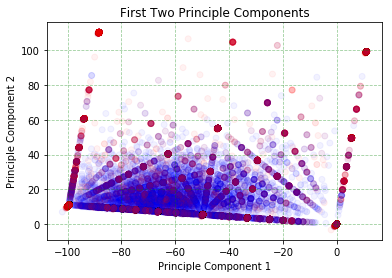

In [4]:
X = df.values
y = target
pcd = PCA(5).fit(X)
reduced = np.dot(df.values, pcd.components_.T)
#fig,ax = plt.subplots(1, figsize=(8, 6))
x = reduced[:, 0][y == 0]
y2 = reduced[:, 1][y == 0]
plt.scatter(reduced[:, 0],reduced[:, 1],alpha = .05,color=np.array(["b", "r"])[y]);
plt.title('First Two Principle Components')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.grid(alpha = .4,c = 'g',ls = '--')
plt.show()

Wow there is a lot of information contained in this plot, but it is somewhat meaningless.  This is nice thought to see that a deepset structure exists in the data.  Lets try to better understand the specific variables that are driving churn.

#### Random Forest: Feature Importance
Here, the plan is to train a random forest, and take a look at the feature importance for each feature that we split on.  This will give us more buisness inuition and let us know what we should include in the model.  This goes back to the above defined Entropy Caclulation.

--------------------------------------------------
Accuracy =  73.82468911131332 %
--------------------------------------------------


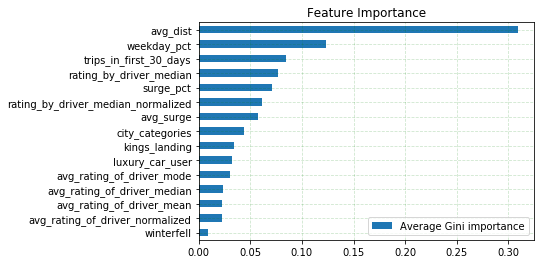

In [5]:
#Set up the Data
X = df.values
y = target
X_train, X_test, y_train, y_test= train_test_split(X,y,shuffle = True)

#Train the Model
model = RF(n_estimators=50)
model.fit(X_train,y_train)

#get the feature scores
feat_scores = pd.DataFrame({'Average Gini importance' : model.feature_importances_},
                           index=df.columns)
feat_scores = feat_scores.sort_values(by='Average Gini importance')

#Plot
feat_scores.plot(kind='barh');
plt.grid(alpha = .2,color = 'g',ls = '--')
plt.title('Feature Importance')
print('-'*50)
print('Accuracy = ',np.sum(model.predict(X_test) == y_test)/len(y_test)*100,'%')
print('-'*50)

Above has a lot of information so I am going to discuss a few things:

**First**: We are already an accuracy of 74% which is awesome, because we are doing almost 10% better than just predicting the majority class.

**Next** we can look and see what was the best method for filling in the missing datapoints.  For rating of driver, the best method was using median followed by the normalized version.  I will be keeping the median version.

As well, the city catagory seems to be a big identifier. From some analysis, it is apparent that some citys have higher churn than others.  This is something where we might want to consider focusing our efforts into one city where there is a higher churn rate and doing AB testing to see how successful our marketing strategy is.  With only the important columns, the GINI importance graph looks like the following:

--------------------------------------------------
Accuracy =  74.0774441411384 %
--------------------------------------------------


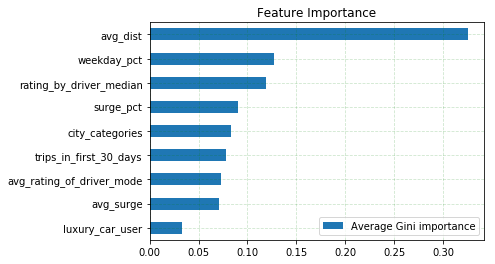

In [6]:
cols = ['avg_dist','weekday_pct','trips_in_first_30_days','surge_pct',
        'rating_by_driver_median','avg_surge','city_categories',
        'luxury_car_user','avg_rating_of_driver_mode']
df = df[cols]
#Set up the Data
X = df.values
y = target
X_train, X_test, y_train, y_test= train_test_split(X,y,shuffle = True)

#Train the Model
model = RF(n_estimators=50)
model.fit(X_train,y_train)

#get the feature scores
feat_scores = pd.DataFrame({'Average Gini importance' : model.feature_importances_},
                           index=df.columns)
feat_scores = feat_scores.sort_values(by='Average Gini importance')

#Plot
feat_scores.plot(kind='barh');
plt.grid(alpha = .2,color = 'g',ls = '--')
plt.title('Feature Importance')
print('-'*50)
print('Accuracy = ',np.sum(model.predict(X_test) == y_test)/len(y_test)*100,'%')
print('-'*50)

Nice! We actually get a little higher accuracy and this gives a few things to look at to better understand how our users decidet whether they are going to continue using the service.  Lets take a look at some histograms that will help us to understand the habits of those who are churning:

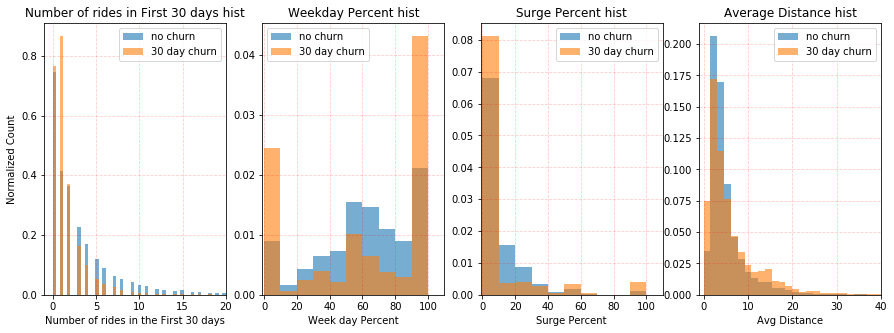

In [7]:
_,ax = plt.subplots(1,4,figsize = (15,5))
reload(C)
C.plot_(df,target,ax);

It is interesting that the Average distance is such a good split because it is hard to see how there is a difference from this hist.  But looking at the other histograms can give us some insight into our users:
1. Number of rides in the First 30 Days:
    - It appears riders who churn take fewer rides in the first 30 days.  This could be a marketing strategy for the future.  By increases incentives to ride early on, we might be able to minimize the churnover in the longrun
2. Weekday Percent:
    - It appears that riders that ride regularly on the weekdays and the weekends tend to churn over less.  This is also useful as we can use this information to give users who ride exclusively on the weekend or weekdays an incentive to ride more regularly.
3. Surge Percent:
    - It appears that the surge percentage is not a driving users away, and actually possibly the opposite.  Users who have a higher surge appear churn over less up to about 40% surge.  After this, it looks fairly equal although with the higher surge rate, there may be a slightly higher rate of churn.  From this plot, I would not say that the surge pricing is driving away users.
    
#### Modeling and ROC curves:
Lets now take a look at how to best model this data.  I will be trying a few different methods of classification, and taking a look at the accuracy, and then also decide on a metric to decide what the best method is.  Looking initally at just the True positive rate _(where we pridicted churnover and they actually churn)_ and the False Positive Rate _(we predicted churn but the user didnt actually churn)_ We can begin to understand the model and plot a ROC curve that represents how well we are predicting the _True Positive Rate_ (TPR) and _False Positive Rate_(FPR).  Once we have this we can define a cost matrix and understand at what point we can maximize the benifit of using the predictions from the model.  

After both of these, I will perform a grid search to maximize the models predictions!

#### Modeling:  
- Tested multiple models
- Found that ADA boost worked the best
- Take a look at the ROC curve for performance
- Ensure that our performance was better than just predicting the majority class (64%)

Traing 4 models:

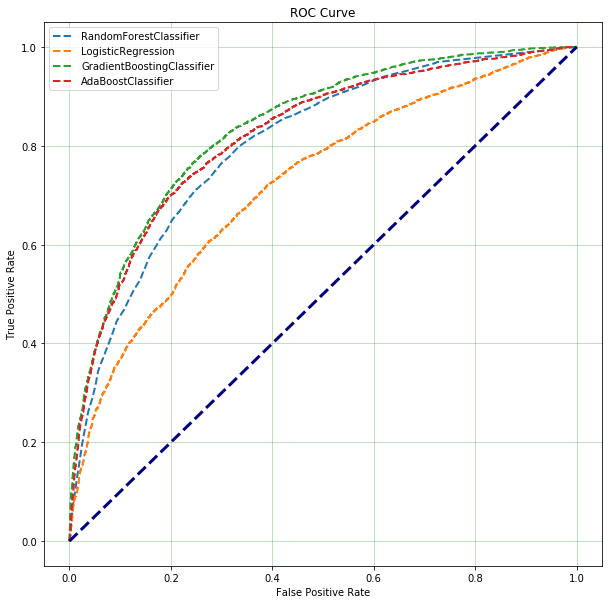

In [8]:
reload(R)
_,ax = plt.subplots(1,1,figsize = (10,10))
models = [RF(n_estimators=50), LR(), GBC(),AD(GBC(),learning_rate=1)]                                             
R.plot_roc(X,y,models,ax)

From the above curve, we can see that Gradient Boosting Classifier is the performing the best at almost all thresholds. We would want to choose a threshhold around the value of _False Positive Rate = .4_

We are looking for a point on this graph where we can minimize the the False Postives and maximize the True positives.  We can see that if we pick a cut off of .4, we can get a true positive rate of over 80% Nice!

Now I am going to plot a Profit Curve to better understand at what point in the ROC curve maximizes our profit from the users.  This is based on how much predicting a user who churns over vs did not churn.  If we predict it and get it right, we can say that it saves the company 10 dollars _(can be scaled differntly)_ and if we predict that they churn over and they actual dont, we give them free rides which costs the company money.  Below is the profit curve & Cost matrix for this:  

||**pred y**|**pred N**|
|:-:|:-:|:-:|
|**actual Y**|10|0|
|**actual N**|-10|0|

The percentage of correct classification for 
model: GradientBoostingClassifier is:  77.373 %
--------------------------------------------------


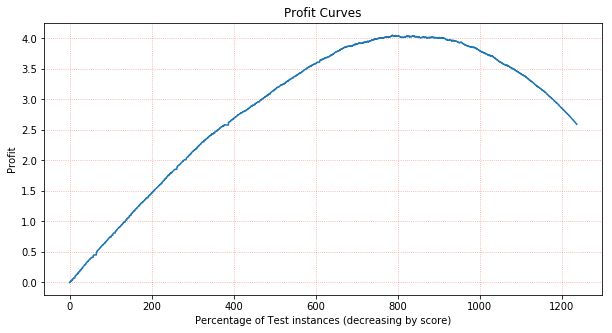

In [9]:
#Define the Cost Matrix
cost_matrix = np.array([[10, -10], [ 0,   0]]).T

#Make the plot
_,ax = plt.subplots(1,1,figsize = (10,5))
models = [GBC()]
#           AD(RF(n_estimators=1),
#              learning_rate=.01,n_estimators=1000)]

#plot out the profit curve for each model
for model in models:
    m,profits,p = F.plot_profit_curve(model, cost_matrix, X_train, X_test,\
                      y_train, y_test,ax)
    
    print('The percentage of correct classification for \nmodel:',
          model.__class__.__name__,
          'is: ',
          np.round(np.sum(m == y_test)/len(y_test)*100,3),
         '%')
    print('-'*50)

**TO DO**
optimize model
understand profit curve output
talk about implications
grid search

### Test:

In [12]:
reload(C)
df = C.read_data('data/churn_test.csv')

df = C.add_target(df)
df = C.clean_rtg_of_driver(df)
df = C.clean_city(df)
df = C.cleaning_avg_rating_by_driver(df)
df = C.remove_july(df)
df = C.clean_luxury_user(df)
cols = ['avg_dist','weekday_pct','trips_in_first_30_days','surge_pct',
        'rating_by_driver_median','avg_surge','city_categories',
        'luxury_car_user','avg_rating_of_driver_mode']
target = df['within_last_30']
df = df[cols]
df.info()
X_test = df.values
y_test = target


<class 'pandas.core.frame.DataFrame'>
Index: 9889 entries, 0 to 9999
Data columns (total 9 columns):
avg_dist                     9889 non-null float64
weekday_pct                  9889 non-null float64
trips_in_first_30_days       9889 non-null int64
surge_pct                    9889 non-null float64
rating_by_driver_median      9889 non-null float64
avg_surge                    9889 non-null float64
city_categories              9889 non-null int64
luxury_car_user              9889 non-null bool
avg_rating_of_driver_mode    9889 non-null float64
dtypes: bool(1), float64(6), int64(2)
memory usage: 705.0+ KB


9889 9889


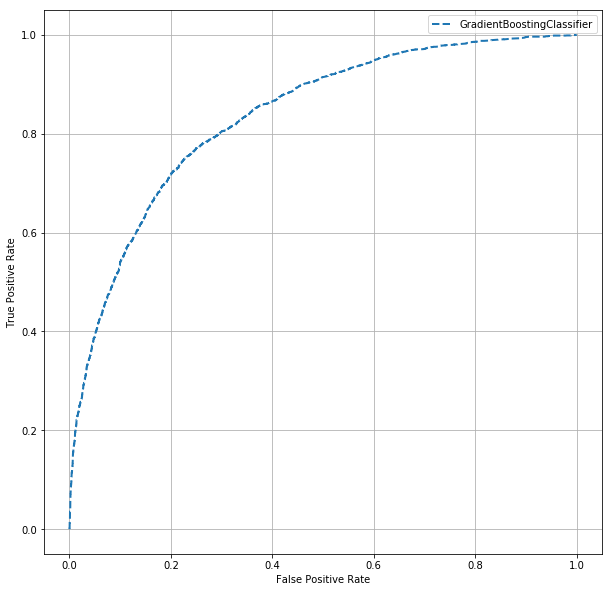

In [14]:
reload(R)
models = [GBC()]
_,_ = plt.subplots(1,1,figsize = (10,10))
for model in models:
    model = model
    model.fit(X_train,y_train)
    test_probs = model.predict_proba(X_test)
    print(len(test_probs),len(y_test))
    TPR_list,FPR_list,ThreshHolds = R.roc_curve(y_test,test_probs[:,0])
    
    plt.plot(FPR_list,TPR_list,
             linestyle = '--',
             linewidth = 2,
             label = model.__class__.__name__)
    
plt.plot([0,0],[1,1],
         color = 'navy',
         linestyle = ':',
         linewidth = 3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend()

The percentage of correct classification for 
model: GradientBoostingClassifier is:  76.944 %
--------------------------------------------------


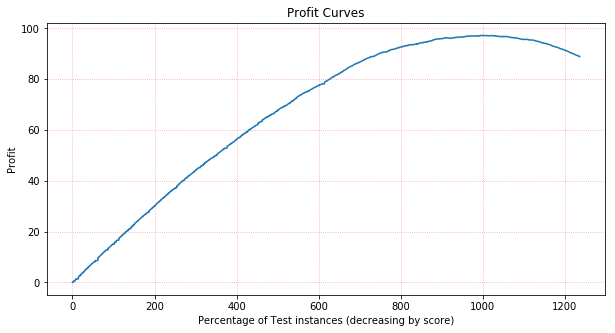

In [15]:
#Define the Cost Matrix
cost_matrix = np.array([[200, -100], [ 0,   0]]).T

#Make the plot
_,ax = plt.subplots(1,1,figsize = (10,5))
models = [GBC()]

#plot out the profit curve for each model
for model in models:
    m,profits,p = F.plot_profit_curve(model, cost_matrix, X_train, X_test,\
                      y_train, y_test,ax)
    
    print('The percentage of correct classification for \nmodel:',
          model.__class__.__name__,
          'is: ',
          np.round(np.sum(m == y_test)/len(y_test)*100,3),
         '%')
    print('-'*50)